In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

test_dir = '/content/drive/MyDrive/FruitinAmazon/test'
train_dir = '/content/drive/MyDrive/FruitinAmazon/train'

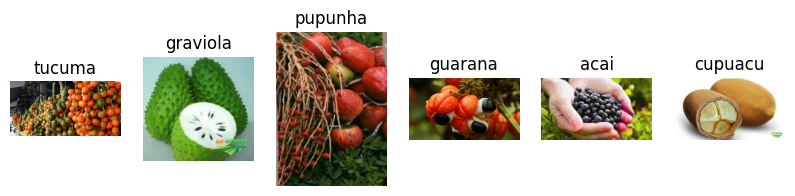

In [40]:
#Task 1: Load and visualize images
import random
from tensorflow.keras.preprocessing import image_dataset_from_directory

def display_sample_images(directory, num_images=6):
    classes = os.listdir(directory)
    plt.figure(figsize=(10, 5))

    for i, class_name in enumerate(classes[:num_images]):
        class_dir = os.path.join(directory, class_name)
        image_name = random.choice(os.listdir(class_dir))
        img_path = os.path.join(class_dir, image_name)
        img = Image.open(img_path)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    plt.show()
display_sample_images(train_dir)

In [41]:
#Task 2: Check for corrupted images
def check_corrupted_images(directory):
    corrupted = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError):
                corrupted.append(img_path)
                os.remove(img_path)
    return corrupted

corrupted_images = check_corrupted_images(train_dir)
if corrupted_images:
    print("Removed corrupted images:", corrupted_images)
else:
    print("No corrupted images found.")

No corrupted images found.


In [42]:
#Task 3: Load and preprocess image data
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2

train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [43]:
#Normalize the data
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [44]:
#Task 4: Build CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(os.listdir(train_dir)), activation='softmax')
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [46]:
#Task 5: Train Model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=250, batch_size=16, callbacks=callbacks)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.1904 - loss: 1.9355

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1879 - loss: 1.9501 - val_accuracy: 0.2222 - val_loss: 2.0589
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.3194 - loss: 1.7029

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 627ms/step - accuracy: 0.3229 - loss: 1.7022 - val_accuracy: 0.1667 - val_loss: 1.9482
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.5249 - loss: 1.5424

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 560ms/step - accuracy: 0.5256 - loss: 1.5351 - val_accuracy: 0.1667 - val_loss: 1.8312
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.4294 - loss: 1.3858

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 555ms/step - accuracy: 0.4332 - loss: 1.3775 - val_accuracy: 0.1667 - val_loss: 1.8106
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.6094 - loss: 1.1276

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 579ms/step - accuracy: 0.6133 - loss: 1.1294 - val_accuracy: 0.1667 - val_loss: 1.8031
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 906ms/step - accuracy: 0.6671 - loss: 1.0135 - val_accuracy: 0.1667 - val_loss: 2.0324
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 756ms/step - accuracy: 0.7912 - loss: 0.8007 - val_accuracy: 0.3333 - val_loss: 2.1344
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 496ms/step - accuracy: 0.8516 - loss: 0.7006 - val_accuracy: 0.2778 - val_loss: 2.0064
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8704 - loss: 0.4925

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 614ms/step - accuracy: 0.8681 - loss: 0.4978 - val_accuracy: 0.2778 - val_loss: 1.7536
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 570ms/step - accuracy: 0.9193 - loss: 0.3330 - val_accuracy: 0.2778 - val_loss: 1.7888
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 587ms/step - accuracy: 0.9332 - loss: 0.2765 - val_accuracy: 0.4444 - val_loss: 2.2048
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 903ms/step - accuracy: 0.9813 - loss: 0.1733 - val_accuracy: 0.2222 - val_loss: 2.4923
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 527ms/step - accuracy: 1.0000 - loss: 0.0698 - val_accuracy: 0.3333 - val_loss: 1.9415
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 1.0000 - loss: 0.0469

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - accuracy: 1.0000 - loss: 0.0460 - val_accuracy: 0.5000 - val_loss: 1.7303
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step - accuracy: 1.0000 - loss: 0.0306 - val_accuracy: 0.5556 - val_loss: 1.9956
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 511ms/step - accuracy: 1.0000 - loss: 0.0200 - val_accuracy: 0.3333 - val_loss: 2.3099
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 963ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.3333 - val_loss: 2.6104
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 506ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.3889 - val_loss: 2.8052
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.3333 - val_loss: 2.8800


In [47]:
#Task 6: Evaluate Model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5000 - loss: 1.7303
Validation Loss: 1.7303
Validation Accuracy: 50.00%


In [48]:
#Task 7: Save and load model
model.save("fruit_classifier.h5")
loaded_model= tf.keras.models.load_model("fruit_classifier.h5")

In [49]:
#Task 8: Make Predictions and Generate Classification Report
from sklearn.metrics import classification_report

In [50]:
def evaluate_model(model, dataset):
    y_true = []
    y_pred = []

    for images,labels in dataset:
        predictions = model.predict(images)
        predicted_labels = np.argmax(predictions, axis=1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted_labels)
        print(classification_report(y_true, y_pred, target_names=os.listdir(train_dir)))

evaluate_model(loaded_model, val_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
              precision    recall  f1-score   support

      tucuma       1.00      1.00      1.00         1
    graviola       0.33      0.50      0.40         2
     pupunha       1.00      0.67      0.80         3
     guarana       0.50      0.80      0.62         5
        acai       0.00      0.00      0.00         4
     cupuacu       0.33      0.33      0.33         3

    accuracy                           0.50        18
   macro avg       0.53      0.55      0.52        18
weighted avg       0.45      0.50      0.46        18

